# Exploring PyDEIMOS

In this notebook, we explore different ingredients that go into the DEIMOS shape measurement method, and see how to optimise its performance.

## Table of contents

<a href="paper_plot">Reproducing plots from the original DEIMOS paper</a>

<a href="gauss_diagnose">Diagnosing simple Gaussian case</a>


In [60]:
## Import the necessary modules
import galsim
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
## Import our script
from deimos import *
from helper import *
from moments import *

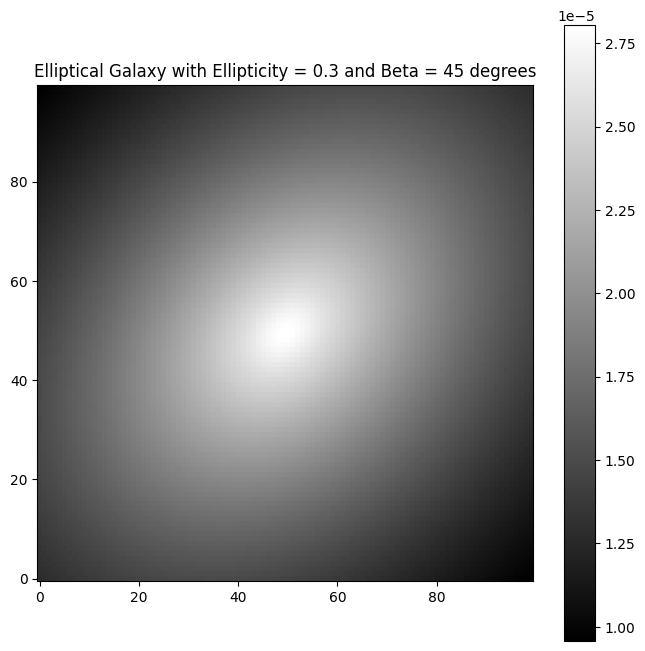

In [62]:
import galsim
import matplotlib.pyplot as plt
import numpy as np  # Ensure numpy is imported for calculations

def create_elliptical_galaxy(ellipticity, beta_deg=0, size=25, pixel_scale=0.2):
    """
    Creates and displays an elliptical galaxy image using GalSim.

    Parameters:
    - ellipticity: The desired ellipticity of the galaxy.
    - beta_deg: The position angle of the galaxy's major axis in degrees. Default is usually 0.
    - size: The size of the galaxy's half-light radius in pixels. Default is usually 25.
    - pixel_scale: The scale of pixels in arcsec/pixel. Default is usually 0.2.
    """
    # ellipticity components
    e1 = ellipticity * np.cos(2 * np.radians(beta_deg))
    e2 = ellipticity * np.sin(2 * np.radians(beta_deg))

    # Create a simple Exponential light profile for the galaxy and apply shear directly
    galaxy = galsim.Exponential(flux=1.0, half_light_radius=size).shear(e1=e1, e2=e2)

    # Define the image size
    image_size = 100  # pixels
    image = galsim.ImageF(image_size, image_size, scale=pixel_scale)

    # Draw the galaxy image
    galaxy.drawImage(image=image)

    
    plt.figure(figsize=(8, 8))
    plt.imshow(image.array, origin='lower', cmap='gray')
    plt.title(f'Elliptical Galaxy with Ellipticity = {ellipticity} and Beta = {beta_deg} degrees')
    plt.colorbar()
    plt.show()


create_elliptical_galaxy(ellipticity=0.3, beta_deg=45)


In [8]:
## Construct the PSF and galaxy models
psf = galsim.Moffat(beta=3, fwhm=3).shear(g1=0.05,g2=0.05)
gal1 = galsim.Exponential(half_light_radius=3).shear(g1=0.1,g2=0.4)
gal4 = galsim.DeVaucouleurs(half_light_radius=1.5).shear(g1=0.1,g2=0.4)

## Draw the galaxy and PSF images
scale = 1.
img_psf = psf.drawImage(scale=scale, method='no_pixel')
img1 = galsim.Convolve([gal1,psf]).drawImage(scale=scale, method='no_pixel')
img4 = galsim.Convolve([gal4,psf]).drawImage(scale=scale, method='no_pixel')

hsm_psf = img_psf.FindAdaptiveMom()
hsm1 = img1.FindAdaptiveMom()
hsm4 = img4.FindAdaptiveMom()

In [9]:
psf_grid = generate_pixelgrid([-0.5,-0.5], img_psf.array.shape, scale=scale)
gal1_grid = generate_pixelgrid([-0.5,-0.5], img1.array.shape, scale=scale)
gal4_grid = generate_pixelgrid([-0.5,-0.5], img4.array.shape, scale=scale)


Let's look at one of the galaxy image and its weight function. 

Note, the vertical axis is flipped, and therefore, the sign of e2 will appear flipped.

Text(0, 0.5, '$n=4$')

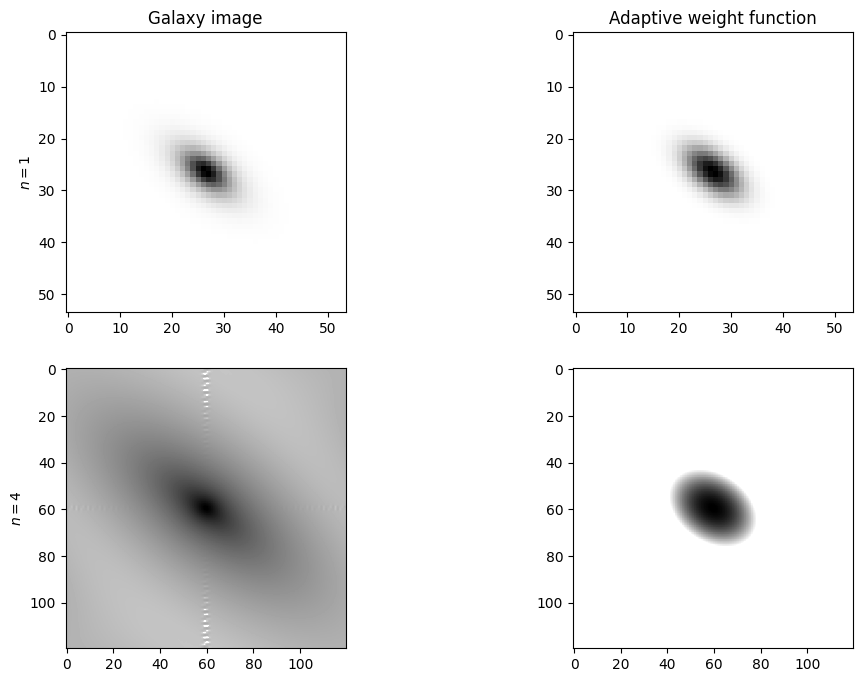

In [10]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(12,8)
ax[0,0].imshow(img1.array, cmap=cm.gray_r)
ax[0,1].imshow(get_weight_image(gal1_grid,hsm1.moments_sigma*scale,hsm1.observed_shape.g1,hsm1.observed_shape.g2),cmap=cm.gray_r)
ax[1,0].imshow(img4.array, cmap=cm.gray_r, norm=LogNorm())
ax[1,1].imshow(get_weight_image(gal4_grid,hsm4.moments_sigma*scale,hsm4.observed_shape.g1,hsm4.observed_shape.g2),cmap=cm.gray_r,norm=LogNorm())
ax[0,0].set_title('Galaxy image'); ax[0,1].set_title('Adaptive weight function')
ax[0,0].set_ylabel(r'$n=1$'); ax[1,0].set_ylabel(r'$n=4$')

<a id="paper_plot"></a>

We will now try to reproduce Figure 1 of Melchior et al. (2012)

In [11]:
## Calling some internal PyDEIMOS routines
psf_grid = generate_pixelgrid([-0.5,-0.5], img_psf.array.shape, scale=scale)
gal1_grid = generate_pixelgrid([-0.5,-0.5], img1.array.shape, scale=scale)
gal4_grid = generate_pixelgrid([-0.5,-0.5], img4.array.shape, scale=scale)

## Calculate the (1,1) deweighted moment and ellipticity as a function of weight size
S = np.linspace(2,30,29) ## units of arcsec
lines = ["#s idx nw0 nw2 nw4 nw6\n"]
idx11 = doublet_to_singlet(1,1)
dat1, dat2 = np.zeros((2*len(S), 6)), np.zeros((2*len(S),6))
kmax = (6+3)*(6+4)//2
psf_moments, gal1_moments, gal4_moments = np.zeros(kmax), np.zeros(kmax), np.zeros(kmax)
for sidx, s in enumerate(S):
    ## If we go by coordinate transformation of Eq. 13, then this is how the invariant size is defined.
    if False:
        s1 = s/(1.-hsm1.observed_shape.g1**2-hsm1.observed_shape.g2**2)
        s4 = s/(1.-hsm4.observed_shape.g1**2-hsm4.observed_shape.g2**2)
        s_psf = s/(1.-hsm_psf.observed_shape.g1**2-hsm_psf.observed_shape.g2**2)
    else:
        s1, s4, s_psf = s, s, s
    
    weight_psf = get_weight_image(psf_grid, s_psf, 0.05, 0.05)
    weight1 = get_weight_image(gal1_grid, s1, hsm1.observed_shape.g1, hsm1.observed_shape.g2)
    weight4 = get_weight_image(gal4_grid, s4, hsm4.observed_shape.g1, hsm4.observed_shape.g2)
    for k in range(kmax):
        m,n = singlet_to_doublet(k)
        psf_moments[k] = measure_moments(m,n,img_psf,psf_grid,weight=weight_psf)
        gal1_moments[k] = measure_moments(m,n,img1,gal1_grid,weight=weight1)
        gal4_moments[k] = measure_moments(m,n,img4,gal4_grid,weight=weight4)
        
    DW1 = generate_deweighting_matrix( s1, hsm1.observed_shape.g1, hsm1.observed_shape.g2, 6)
    DW4 = generate_deweighting_matrix( s4, hsm4.observed_shape.g1, hsm4.observed_shape.g2, 6)
    DW_psf = generate_deweighting_matrix( s_psf, 0.05, 0.05, 6)
    
    dat1[2*sidx][0] = s; dat1[2*sidx+1][0] = s
    dat1[2*sidx][1] = 1; dat1[2*sidx+1][1] = 4
    dat2[2*sidx][0] = s; dat2[2*sidx+1][0] = s
    dat2[2*sidx][1] = 1; dat2[2*sidx+1][1] = 4
    
    for nw in [0,2,4,6]:
        kmax = (nw+3)*(nw+4)//2
        deweighted_psf_moments = np.dot(DW_psf[:,:kmax], psf_moments[:kmax])
        deweighted_img1_moments = np.dot(DW1[:,:kmax], gal1_moments[:kmax])
        deweighted_img4_moments = np.dot(DW4[:,:kmax], gal4_moments[:kmax])
        
        index = 2 + nw // 2  

        dat1[2 * sidx, index] = deweighted_img1_moments[idx11]
        dat1[2 * sidx + 1, index] = deweighted_img4_moments[idx11]
        
        psf_corr_moments1 = psf_correction(deweighted_img1_moments, deweighted_psf_moments)
        psf_corr_moments4 = psf_correction(deweighted_img4_moments, deweighted_psf_moments)
        
        dat2[2 * sidx, index] = moments_to_ellipticity(psf_corr_moments1,etype='chi')[1]
        dat2[2 * sidx+1, index] = moments_to_ellipticity(psf_corr_moments4,etype='chi')[1]
        
unweighted_img1_moment = measure_moments(1,1,img1,gal1_grid,weight=1.)
unweighted_img4_moment = measure_moments(1,1,img4,gal4_grid,weight=1.)

kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> value: 45
kdw_max type: <class 'int'> value: 6
kmax type: <class 'int'> va

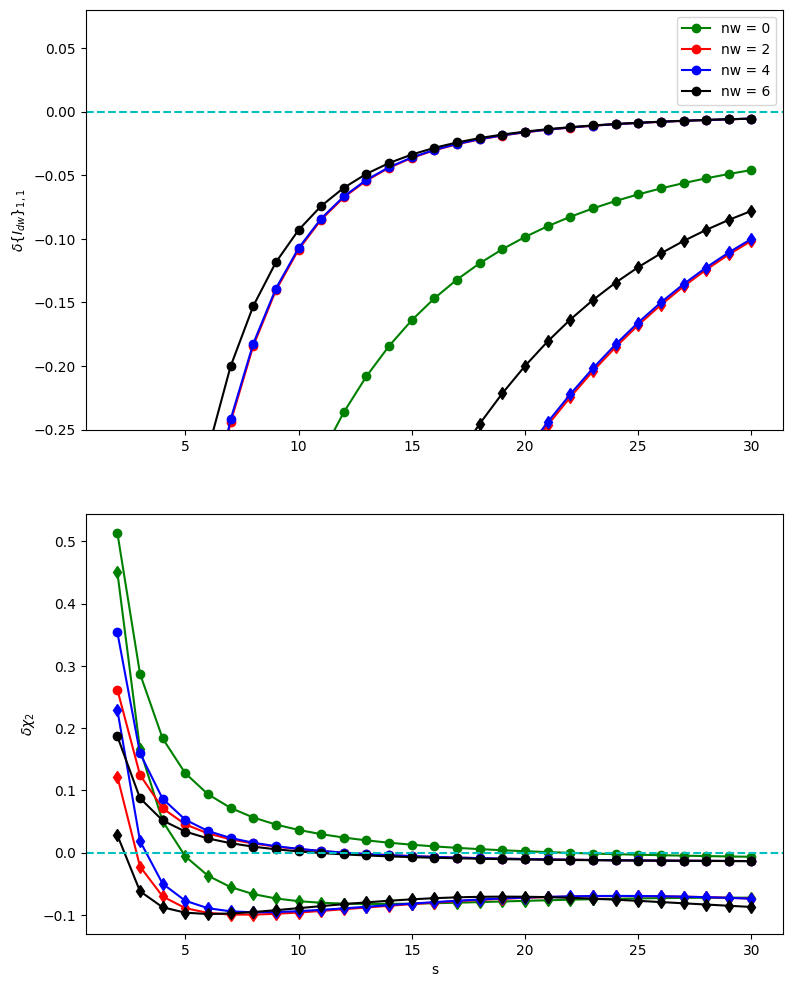

In [58]:
## Make the plot 
fig, ax = plt.subplots(2)
fig.set_size_inches([9,12])
nw_values = ['0','2','4','6']
g2 = galsim.Shear(g1=0.1,g2=0.4).e2
for nw, color in zip(nw_values, colors):
    identifier_columns = 2
    index = nw_values.index(nw) + identifier_columns
    ax[0].plot(S, (dat1[dat1[:, 1] == 1, index] / unweighted_img1_moment - 1), 'o-', color=color, label=f'nw = {nw}')
    ax[0].plot(S, (dat1[dat1[:, 1] == 4, index] / unweighted_img4_moment - 1), 'd-', color=color)
    ax[1].plot(S, (dat2[dat2[:, 1] == 1, index] / g2 - 1), 'o-', color=color, label=f'nw = {nw}')
    ax[1].plot(S, (dat2[dat2[:, 1] == 4, index] / g2 - 1), 'd-', color=color)

    
ax[1].set_xlabel('s')
ax[0].set_ylabel(r'$\delta\{I_{dw}\}_{1,1}$')
ax[1].set_ylabel(r'$\delta \chi_2$')
ax[0].axhline(0.0,color='c',ls='--')
ax[1].axhline(0.0,color='c',ls='--')
ax[0].set_ylim([-0.25,0.08])
ax[0].legend(loc='best')

Our results do not look like the plot above from the paper. We will do some quick sanity check to ensure that we are doing this correctly

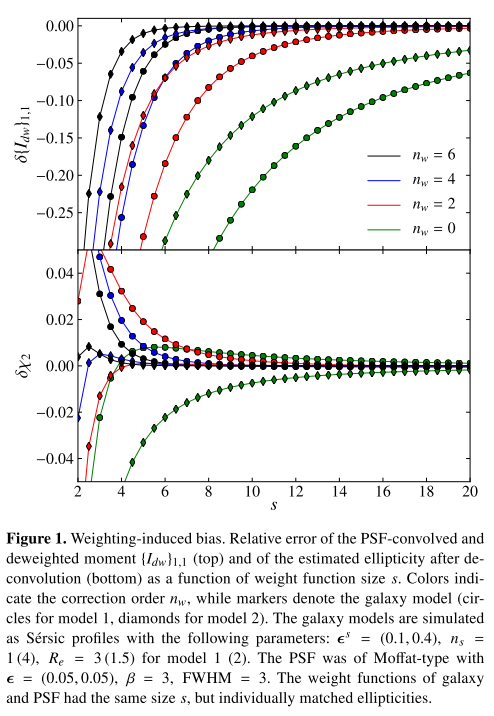

Are we analysing the images correctly? Do our functions do what they're supposed to do? Can we at least confirm if our nw=0 case makes sense, where the deweighted moments equal weighted moments?

In [36]:
## Verify we get the adaptive moments correctly
hsm1 = img1.FindAdaptiveMom()
weight1 = get_weight_image(gal1_grid, hsm1.moments_sigma*scale, hsm1.observed_shape.g1, hsm1.observed_shape.g2)
weighted_moments1 = np.zeros(6)
for k in xrange(6):
    i, j = singlet_to_doublet(k)
    weighted_moments1[k] = measure_moments(i,j,img1,gal1_grid,weight=weight1)

weighted_ellipiticity = moments_to_ellipticity(weighted_moments1,etype='chi')
print(hsm1.observed_shape.e1, weighted_ellipiticity[0])
print(hsm1.observed_shape.e2, weighted_ellipiticity[1])
print(hsm1.moments_sigma*scale/np.sqrt(2), moments_to_size(weighted_moments1,size_type='det')

adaptive_moments1 = shapedata_to_moments(hsm1)
print adaptive_moments1, (weighted_moments1[3:6]/weighted_moments1[0])/scale**2

SyntaxError: '(' was never closed (119904932.py, line 12)

In [ ]:
print np.array(shapedata_to_moments(hsm1)), gal1_moments[3:6]/gal1_moments[0]
print np.array(shapedata_to_moments(hsm4)), gal4_moments[3:6]/gal4_moments[0]

print unweighted_img1_moment, gal1_moments[4]/(gal1_moments[0]*unweighted_img1_moment)
print unweighted_img4_moment, gal4_moments[4]/(gal4_moments[0]*unweighted_img4_moment)
#print galsim.Image(weight4).FindAdaptiveMom()

print hsm4

#print 12.6773246/2.83132098, 9.35219682/1.27965868, 5.72970995/2.08869547
#print 8.77186870/1.96038587

## Diagnosing simple Gaussian case

Let's start by analysing the case of a simple elliptical Gaussian, where analytical calculations are possible if needed.

In [ ]:
gauss_shape = galsim.Shear(e1=0.3, e2=0.4)
gauss = galsim.Gaussian(sigma=3.7).shear(gauss_shape)
gscale = 1.
gauss_img = gauss.drawImage(scale=gscale, method='no_pixel')
hsm = gauss_img.FindAdaptiveMom(round_moments=False)

gauss_grid = generate_pixelgrid([-0.5,-0.5],gauss_img.array.shape,scale=gscale)
weight_img = get_weight_image(gauss_grid, hsm.moments_sigma*gscale, hsm.observed_shape.g1, hsm.observed_shape.g2)

nw = 6
unweighted_moments = np.zeros(6)
weighted_moments = np.zeros((nw+3)*(nw+4)/2)
for k in xrange((nw+3)*(nw+4)/2):
    i,j = singlet_to_doublet(k)
    if k<6:
        unweighted_moments[k] = measure_moments(i,j,gauss_img.array, gauss_grid,weight=1.)
    weighted_moments[k] = measure_moments(i,j,gauss_img.array, gauss_grid, weight=weight_img)
    
DW = generate_deweighting_matrix(hsm.moments_sigma*gscale, hsm.observed_shape.g1, hsm.observed_shape.g2, nw=nw)
dDW = DW - np.eye(6,DW.shape[1])
deweighted_moments = np.dot(DW, weighted_moments)

Let's ensure that the Gaussian looks okay

In [ ]:
print weighted_moments[3:6]/weighted_moments[0]
print shapedata_to_moments(hsm)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(gauss_img.array, cmap=cm.gray_r)
ax[1].imshow(weight_img, cmap=cm.gray_r)
ax[0].set_title('Gaussian image'); ax[1].set_title('Adaptive weight function')

Do we recover the input quantities from weighted moments?

In [ ]:
print "Input ellipticity = ", gauss_shape
print "Recovered ellipticity = ", moments_to_ellipticity(deweighted_moments)
print "Input sigma = ", gauss.original.sigma, "or", hsm.moments_sigma
print "Measured sigma = ", moments_to_size(deweighted_moments, size_type='det',flux_normalized=True)

While we are able to recover the ellipticity very well from the deweighted moments, the sizes don't agree indicating that the deweighted moments don't quite match the unweighted moments. We now compare them directly.

In [ ]:
print "Unweighted moments = ", np.round(unweighted_moments,10)
print "Deweighted moments = ", np.round(deweighted_moments,10)
print "Ratio of second order deweighted moments to corresponding unweighted moments = \n",((deweighted_moments[3:]/unweighted_moments[3:])/deweighted_moments[0])**0.5

It appears that all the deweighted second order moments fall short of their true values by the same ratio (denoted as $\Delta(n,s)$ in Melchior et al. (2012), which leaves the ellipticity unaffected but affects the size calculation. This ratio is exactly the ratio between Measured sigma and Input sigma.

Let us now visualise the deweighting matrix. We will discard the unity entries along the diagonal to improve contrast.

In [ ]:
## Visualize the deweighting matrix
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
vmax = max(dDW.max(),-dDW.min())
_im = ax.imshow(dDW, cmap=cm.bwr, vmin=-vmax, vmax=vmax)
_cbar = fig.colorbar(_im,ax=ax,orientation='horizontal')
fig.get_size_inches()

The elements in the deweighting matrix corresponding to the higher order moments are small. This is expected as the Taylor expansion of inverse Gaussian is a convergent series. However, we need to ensure that the correction terms with the higher order moments converge quick enough.

We now visualise the correction terms to the deweighted moments (0,2), (1,1) and (2,0), which go into the calculation of shear. We have inverted the sign of correction terms to (0,2) since they influence e1 in opposite direction wrt (2,0).

The first group corresponds to the weighted second moments themselves. The successive groups correspond to nw = 2, 4, 6.

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
#ax.plot(-(DW[3,:]*weighted_moments),'.-',label='(0,2)')
#ax.plot(DW[5,:]*weighted_moments,'.-',label='-(2,0)')
#ax.plot(DW[4,:]*weighted_moments,'.--',label='(1,1)')
for nw in [0,2,4,6]:
    kmin = (nw+2)*(nw+3)/2
    kmax = (nw+3)*(nw+4)/2
    ax.plot(nw, -np.dot(DW[3,kmin:kmax],weighted_moments[kmin:kmax]),'b*')
    ax.plot(nw, np.dot(DW[5,kmin:kmax],weighted_moments[kmin:kmax]),'g*')
    ax.plot(nw, np.dot(DW[4,kmin:kmax],weighted_moments[kmin:kmax]),'r*')
#ax.plot(weighted_moments_e1/hsm.moments_sigma**order,'*-',label='wmom e1')
#ax.plot(weighted_moments_e2/hsm.moments_sigma**order,'d-',label='wmom e2')
#ax.set_yscale('log')
#ax.set_ylim(1e-3,1e3)
ax.axhline(0.0,color='k',ls='--')
ax.legend(loc='best')

In [ ]:
print moments_to_ellipticity(weighted_moments), hsm.observed_shape
print moments_to_ellipticity(deweighted_moments, etype='chi')
print moments_to_size(weighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print moments_to_size(deweighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print moments_to_size(unweighted_moments,size_type='det',flux_normalized=True)/hsm.moments_sigma
print galsim.Image(weight_img).FindAdaptiveMom().moments_sigma

In [ ]:
order = [ ]
for k in xrange(45):
    i,j = singlet_to_doublet(k)
    order.append(i+j)
order = np.array(order)

Here,we explore if it's possible to calculate unweighted moments for Airy PSFs at all

In [ ]:
pix = 0.1
airy = galsim.Airy(lam=800, diam=1.2)
epsf = galsim.Convolve([airy,galsim.Gaussian(sigma=3.0)])
fiducial_psf_img = epsf.drawImage(scale=pix/5.,method='no_pixel')
fiducial_size = fiducial_psf_img.array.shape[0]

S = np.linspace(0.5*fiducial_size,10*fiducial_size,25).astype(int)[:8]
moments = np.zeros((len(S),3))

for idx, sz in enumerate(S):
    psf_img = galsim.Image(sz,sz)
    psf_img = epsf.drawImage(image=psf_img, scale=pix/5., method='no_pixel')
    grid = generate_pixelgrid([-0.5,-0.5],psf_img.array.shape,scale=pix/5.)
    moments[idx,0]= measure_moments(0,2,psf_img,grid,weight=1.,A=None)
    moments[idx,1]= measure_moments(2,0,psf_img,grid,weight=1.,A=None)
    moments[idx,2]= measure_moments(1,1,psf_img,grid,weight=1.,A=None)
 

The Airy PSF looks like this, where it looks like it has fairly died out.

In [ ]:
plt.plot(psf_img.array[916-125:916+125,(psf_img.array.shape[0]+1)/2])
plt.yscale('linear')

However, as the image size is increased, the quadrupole moments increase without any bound. So, formally, unweighted moments do not even exist for Airy-like PSF. Therefore, there is no 'true' value to which the deweighted moments need to be compared with.

In [ ]:
plt.plot(S,moments[:,0],'o-',label='(0,2)')
plt.plot(S[::-1],moments[:,1],'*-',label='(2,0)')
plt.legend(loc='best')

In [ ]:
print psf_img.array[(psf_img.array.shape[0]+1)/2,(psf_img.array.shape[0]+1)/2]
print psf_img.array.max(), np.where(psf_img.array==psf_img.array.max())

In [ ]:
(psf_img.array.shape[0]+1)/2

In [ ]:
import math
N = np.arange(0,10,1.).astype(int)
Nfact = np.array([math.factorial(nn) for nn in N])
x0 = 6.
plt.plot(N,x0**N/Nfact,'o-')


In [32]:
from moments import shapedata_to_moments

ImportError: cannot import name 'shapedata_to_moments' from 'moments' (/Users/raghavchari/Desktop/deimos-master/moments.py)

In [31]:
def shapedata_to_moments(shapedata):
    if not isinstance(shapedata, galsim.hsm.ShapeData):
        raise TypeError("Input to shapedata_to_moments must be an object of class ShapeData")

    e1, e2 = shapedata.observed_shape.e1, shapedata.observed_shape.e2
    trace = shapedata.moments_sigma**2/np.sqrt(1.-e1**2-e2**2)

    M11 = trace*(1.+e1)*0.5
    M22 = trace*(1.-e1)*0.5
    M12 = trace*e2*0.5

    return M22, M12, M11

In [30]:
img4.array.min()

-2.3034822e-07